In [2]:
import torch
from IF import *
from IF.train_model import *
from proutils import *
import numpy as np
import kmedoids
from joblib import Parallel, delayed
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from aix360.algorithms.protodash import ProtodashExplainer
from scipy.spatial.distance import cosine
from collections import Counter
import community

model = LinearModel()
model.load_state_dict(torch.load('data/main_model.pth'))
model.eval()  # Set the model to evaluation mode
ifem=np.load("data/influence_scores.npy")
dmem=torch.load('data/embeds_DM.pt')


train_embeddings = torch.load('data/train_embeddings.pt')
train_labels = torch.load('data/train_labels.pt')
test_embeddings = torch.load('data/test_embeddings.pt')
test_labels = torch.load('data/test_labels.pt')
mod_pred=torch.argmax(model(test_embeddings), dim=1)


def surrogate_fidelity(prototypes):
    smodel = fit_model(test_embeddings[prototypes], mod_pred[prototypes])
    smodel.eval()
    with torch.no_grad():
        outputs = torch.argmax(smodel(test_embeddings), dim=1)
        accuracy = (outputs == mod_pred).sum().item() / len(mod_pred)
    return accuracy

/tmp/ipykernel_3182087/1897988408.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('data/main_model.pth'))
/tmp/ipykernel_3182087/189798

## Louvain

In [3]:
ifem.argsort(axis=1)

array([[28682, 17606, 37713, ...,  7879, 35046, 12855],
       [12855, 35046,  7879, ..., 37713, 17606, 28682],
       [12855, 35046,  7879, ..., 37713, 17606, 28682],
       ...,
       [28682, 17606, 37713, ...,  7879, 35046, 12855],
       [12855, 35046,  7879, ..., 37713, 17606, 28682],
       [12855, 35046,  7879, ..., 37713, 17606, 28682]])

In [8]:
aide_em=aide(ifem, train_embeddings, test_embeddings, 10)
G = nx.Graph()
for i, embs in enumerate(aide_em):
    G.add_node(i, feature=test_embeddings[i].numpy(), bipartite=0)
    for ind, influence in embs:
        G.add_node(f'ex-{ind}', feature=train_embeddings[ind].numpy(), bipartite=1)
        G.add_edge(i, f'ex-{ind}', weight=influence)


import community

def compute_embedding_similarity(graph, embedding_key="feature"):

    similarity_dict = {}

    # Extract node embeddings
    embeddings = {node: graph.nodes[node][embedding_key] for node in graph.nodes}

    # Compute pairwise similarity for edges
    for u, v in graph.edges():
        if u in embeddings and v in embeddings:
            similarity = cosine_similarity(
                [embeddings[u]], [embeddings[v]]
            )[0, 0]
            similarity_dict[(u, v)] = similarity
        else:
            similarity_dict[(u, v)] = 0

    return similarity_dict


def bilouvain_with_embeddings(graph, resolution=2.1, alpha=0.5):

    if not nx.is_bipartite(graph):
        raise ValueError("Input graph must be bipartite.")

    # Compute embedding similarity
    embedding_similarity = compute_embedding_similarity(graph)
    min_sim = min(embedding_similarity.values())
    if min_sim < 0:
        embedding_similarity = {k: v - min_sim for k, v in embedding_similarity.items()}
    # Update edge weights
    for u, v, data in graph.edges(data=True):
        topology_weight = data.get("weight", 1)
        embedding_weight = embedding_similarity.get((u, v), 0)
        combined_weight = alpha * embedding_weight + (1 - alpha) * topology_weight
        data["weight"] = combined_weight

    # partition = community.best_partition(graph, resolution=resolution, random_state=12)
    partition = nx.community.louvain_communities(graph, weight=combined_weight, resolution=resolution, seed=123)
    
    # Convert partition to list of sets
    # communities = {}
    # for node, comm_id in partition.items():
    #     communities.setdefault(comm_id, set()).add(node)

    # return list(communities.values())
    return partition

def get_prototype_bipartite0(graph, communities, bipartite_key="bipartite"):

    prototypes = {}

    for i, community in enumerate(communities):
        # Filter nodes with bipartite=0
        bipartite_0_nodes = [node for node in community if graph.nodes[node].get(bipartite_key) == 0]

        if not bipartite_0_nodes:
            prototypes[i] = None
            continue

        # Extract embeddings for bipartite=0 nodes
        embeddings = {
            node: graph.nodes[node]["feature"]
            for node in bipartite_0_nodes
            if "feature" in graph.nodes[node]
        }

        if not embeddings:
            prototypes[i] = None
            continue

        # Compute the centroid of embeddings
        centroid = np.mean(list(embeddings.values()), axis=0)

        # Find the node closest to the centroid
        prototype = min(
            embeddings.keys(),
            key=lambda node: np.linalg.norm(embeddings[node] - centroid)
        )

        prototypes[i] = prototype

    return prototypes

def get_representative_bipartite1(graph, communities, bipartite_key="bipartite", n=10):

    representatives = {}

    for i, community in enumerate(communities):
        # Filter nodes with bipartite=1
        bipartite_1_nodes = [node for node in community if graph.nodes[node].get(bipartite_key) == 1]

        if not bipartite_1_nodes:
            representatives[i] = []
            continue

        # Compute neighbors of each bipartite=1 node within the community
        neighbor_sets = {
            node: set(graph.neighbors(node)) & community
            for node in bipartite_1_nodes
        }

        # Initialize coverage and selected nodes
        selected_nodes = []
        covered_neighbors = set()

        for _ in range(min(n, len(bipartite_1_nodes))):
            # Select the node that maximizes additional coverage
            best_node = max(
                bipartite_1_nodes,
                key=lambda node: len(neighbor_sets[node] - covered_neighbors)
            )

            selected_nodes.append(best_node)
            covered_neighbors.update(neighbor_sets[best_node])
            bipartite_1_nodes.remove(best_node)

        # representatives[i] = [list(graph.nodes).index(node) for node in selected_nodes]
        representatives[i] = selected_nodes

    return representatives

def compute_coverage(graph, communities, representatives, bipartite_key="bipartite"):

    total_coverage = 0
    total_nodes = 0

    for i, community in enumerate(communities):
        # Filter nodes with bipartite=0
        bipartite_0_nodes = [node for node in community if graph.nodes[node].get(bipartite_key) == 0]

        if not bipartite_0_nodes or i not in representatives:
            continue

        # Compute neighbors of representative samples
        # rep_nodes = [list(graph.nodes)[index] for index in representatives[i]]
        rep_nodes = representatives[i]
        rep_neighbors = set(rep_nodes)
        # for rep in rep_nodes:
        #     rep_neighbors.update(graph.neighbors(rep))

        # Compute Jaccard similarity for each bipartite=0 node
        for node in bipartite_0_nodes:
            node_neighbors = set(graph.neighbors(node))
            intersection = len(node_neighbors & rep_neighbors)
            union = min(len(rep_neighbors), len(node_neighbors))
            # union = len(node_neighbors | rep_neighbors)
            total_coverage += intersection / union if union > 0 else 0
            total_nodes += 1

    return total_coverage / total_nodes if total_nodes > 0 else 0


def int_clus_sim(communs):
    ics=[]
    for commun in communs:
        ints=[i for i in commun if isinstance(i, int)]
        if len(ints)<2:
            ics.append(1)
        else:
            elemnts=test_embeddings[ints]
            ics.append(np.mean(cosine_similarity(elemnts)[np.triu_indices(len(elemnts), k=1)]))
    return sum(ics)/len(ics)


In [5]:
def mg_mets(resolution):    
    
    communities = bilouvain_with_embeddings(G, resolution=resolution, alpha=0)
    sims=int_clus_sim(communities)
    prototypes = get_prototype_bipartite0(G, communities)
    mglop=list(prototypes.values())
    representatives = get_representative_bipartite1(G, communities, n=20)
    covs=compute_coverage(G, communities, representatives)
        
    return mglop, covs, sims
# mglop, covs, sims=mg_mets(0.2)

## FFC experiment for all methods

In [40]:
[len(i) for i in mglop]

[15, 30, 49, 84, 93, 98]

In [25]:
len(bilouvain_with_embeddings(G, resolution=3.3))

125

Epoch [1/5], Loss: 2.3329
Epoch [2/5], Loss: 2.1332
Epoch [3/5], Loss: 1.9453
Epoch [4/5], Loss: 1.7704
Epoch [5/5], Loss: 1.6096
Finished training
Epoch [1/5], Loss: 2.2757
Epoch [2/5], Loss: 2.0762
Epoch [3/5], Loss: 1.8907
Epoch [4/5], Loss: 1.7206
Epoch [5/5], Loss: 1.5668
Finished training
Epoch [1/5], Loss: 2.2829
Epoch [2/5], Loss: 2.0412
Epoch [3/5], Loss: 1.8210
Epoch [4/5], Loss: 1.6246
Epoch [5/5], Loss: 1.4531
Finished training
Epoch [1/5], Loss: 2.1706
Epoch [2/5], Loss: 1.9007
Epoch [3/5], Loss: 1.6616
Epoch [4/5], Loss: 1.4542
Epoch [5/5], Loss: 1.2790
Finished training
Epoch [1/5], Loss: 2.3594
Epoch [2/5], Loss: 1.9652
Epoch [3/5], Loss: 1.7115
Epoch [4/5], Loss: 1.4953
Epoch [5/5], Loss: 1.3123
Finished training
Epoch [1/5], Loss: 2.4230
Epoch [2/5], Loss: 2.0289
Epoch [3/5], Loss: 1.7787
Epoch [4/5], Loss: 1.5623
Epoch [5/5], Loss: 1.3781
Finished training


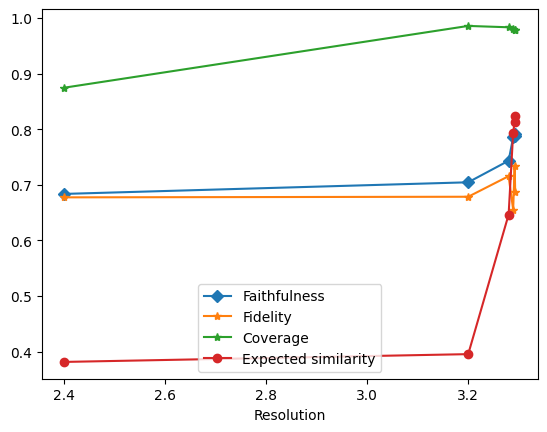

In [9]:
def compute_metrics(i):
    mglop, cov, sim=mg_mets(i)
    acc = nearest_medoid_accuracy(test_embeddings, mod_pred, mglop)
    fid=surrogate_fidelity(mglop,)    
    return acc, fid,mglop, cov, sim
# Parallel computation
N_values=[2.4, 3.2, 3.28, 3.289, 3.292, 3.293]
results = Parallel(n_jobs=-1)(delayed(compute_metrics)(i) for i in N_values)
# Unpack results into separate lists
accs,fids, mglop, covs, sims = zip(*results)

accs=np.array(accs)
fids=np.array(fids)
sims=np.array(sims)
covs=np.array(covs)
plt.plot(N_values, accs, marker='D', label='Faithfulness')
plt.plot(N_values, fids, marker='*', label='Fidelity')
plt.plot(N_values, covs, marker='*', label='Coverage')
plt.plot(N_values, sims, marker='o', label='Expected similarity')
plt.xlabel("Resolution")
plt.legend()
plt.show()

In [13]:
# Generate the lists of prototypes for all methods with differen N
N_values=[len(i) for i in mglop]
def generate_prototypes(K):
    N=N_values[K]
    explainer = ProtodashExplainer()
    weights, protodash, _ = explainer.explain(test_embeddings, test_embeddings, m=N, kernelType = 'Gaussian')
    
    return {
        
        "KMEx": find_prototypes(test_embeddings.detach(), mod_pred, N),
        "DM": find_prototypes(dmem, mod_pred, N),
        "PD": protodash,
        "InfProto": mglop[K]
    }

n_jobs = -1 
all_protos = Parallel(n_jobs=n_jobs)(
    delayed(generate_prototypes)(K)
    for K in tqdm(range(len(N_values)))
)

100%|██████████| 6/6 [00:00<00:00, 8009.49it/s]


In [46]:
# aide_em=aide(ifem, train_embeddings, test_embeddings, 30, coverage=True)
def maximize_coverage(arrays, num_elements):
    # Flatten the arrays to count the frequency of each element
    element_counts = Counter(el for array in arrays for el in array)
    # Initialize the selected set
    selected_set = set()
    
    # Iteratively choose the elements
    for _ in range(num_elements):
        # Select the element with the highest count
        best_element = max(element_counts, key=element_counts.get)
        selected_set.add(best_element)
        
        # Update the counts by removing the chosen element's impact
        element_counts.pop(best_element, None)
    
    # Compute coverage for each array
    coverage = [
        len(set(array).intersection(selected_set)) / len(array) for array in arrays
    ]
    
    return sum(coverage)/len(coverage)

def coverage(prots,N=30, bin=False, popularity=True):
    distances = cosine_similarity(test_embeddings, test_embeddings[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            print(f'label {i}')
            cov=maximize_coverage(np.array(aide_em)[idx], 30)
            covs.append(cov)
    return sum(covs)/len(covs)

In [47]:
aide_em=aide(ifem, train_embeddings, test_embeddings, 20, coverage=True)
# prs=find_representative_samples(X_test, X_train, influence_scores, 20, 20, alpha=0.6)


def coverage1(prots,N=30, bin=False, popularity=True):
    distances = cosine_similarity(test_embeddings, test_embeddings[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            gx=[i[0] for i in Counter(np.array(aide_em)[idx].flatten()).most_common(20)]
        else:
            gx=aide_em[prots[i]]
        for j in idx:
            if bin:
                if len(set(aide_em[j]).intersection(set(gx)))>N:
                    covs.append(1)
                else:
                    covs.append(0)
            else:
                covs.append(len(set(aide_em[j]).intersection(set(gx)))/len(aide_em[j]))
    return sum(covs)/len(covs)

In [14]:
all_protos_np=np.array(all_protos)
# torch.save(all_protos_np, 'data/allprotoscif.npy')
# all_protos_np=torch.load('data/allprotoscif.npy')

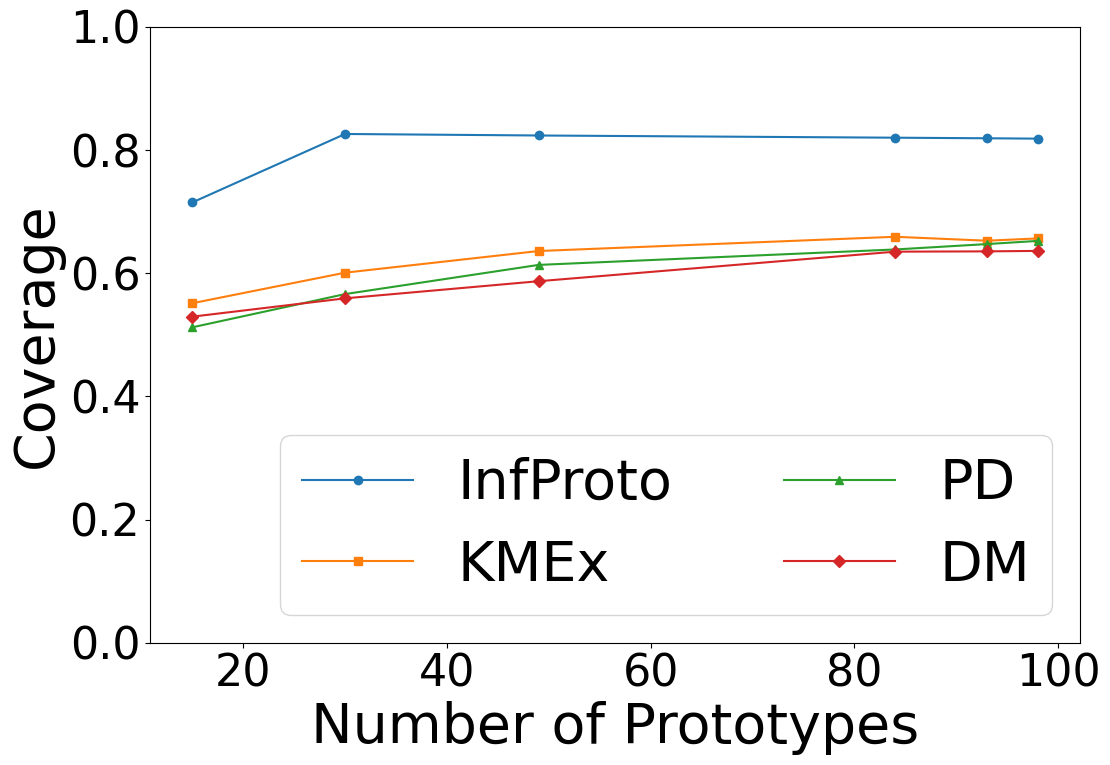

In [61]:
# all_protos_np=np.array(all_protos)
# mglop_cov=[]
protodash_cov=[]
dknn_cov=[]
dmodels_cov=[]
for i in range(len(N_values)):
#     mglop_cov.append(coverage(list(all_protos_np[i].values())[0],N=10, bin=True, popularity=True))
    dknn_cov.append(coverage1(list(all_protos_np[i].values())[0],N=10, bin=False, popularity=True))
    dmodels_cov.append(coverage1(list(all_protos_np[i].values())[1],N=10, bin=False, popularity=True))
    protodash_cov.append(coverage1(list(all_protos_np[i].values())[2],N=10, bin=False, popularity=True))
   


N_values=[len(i) for i in mglop]
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.plot(N_values, np.array(covs)-0.16, marker='o', linestyle='-', label='InfProto')
plt.plot(N_values, dknn_cov, marker='s', linestyle='-', label='KMEx')
plt.plot(N_values, protodash_cov, marker='^', linestyle='-', label='PD')
plt.plot(N_values, dmodels_cov, marker='D', linestyle='-', label='DM')
plt.rcParams.update({'font.size': 40})
plt.xlabel("Number of Prototypes", fontsize=40)
plt.ylabel("Coverage", fontsize=40)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend(ncol=2, loc='lower right')
plt.savefig("Figures/cov_cifar.pdf", bbox_inches='tight',format="pdf")
plt.show()

#### Coverage

##### Similarity of prototypes

In [ ]:
# Intersection

algorithms = ['mglop', 'mglop2', 'dknn', 'dm', 'protodash']
N_values = range(10, 101, 10)  # Increasing N values from 10 to 80
intersections = {f"{algo1} ∩ {algo2}": [] for i, algo1 in enumerate(algorithms) for algo2 in algorithms[i + 1:]}


# Extract intersections between algorithm outputs
for i, outputs in enumerate(all_protos):
    for j, algo1 in enumerate(algorithms):
        for algo2 in algorithms[j + 1:]:
            intersection_size = len(set(outputs[algo1]) & set(outputs[algo2]))
            intersections[f"{algo1} ∩ {algo2}"].append(intersection_size)

# Plotting the results
line_styles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', 'D', '^', 'v', 'P']

plt.figure(figsize=(12, 8))
for (label, sizes), linestyle, marker in zip(intersections.items(), line_styles, markers):
    plt.plot(N_values, sizes, linestyle=linestyle, marker=marker, label=label)

plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Intersection Size")
plt.title("Intersection Size vs Number of Elements (N) for Algorithm Outputs")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)

# Save the plot as a PDF
# plt.savefig("Figures/intersection_plot.pdf", format="pdf")

# Show the plot
plt.show()

In [ ]:
N_values

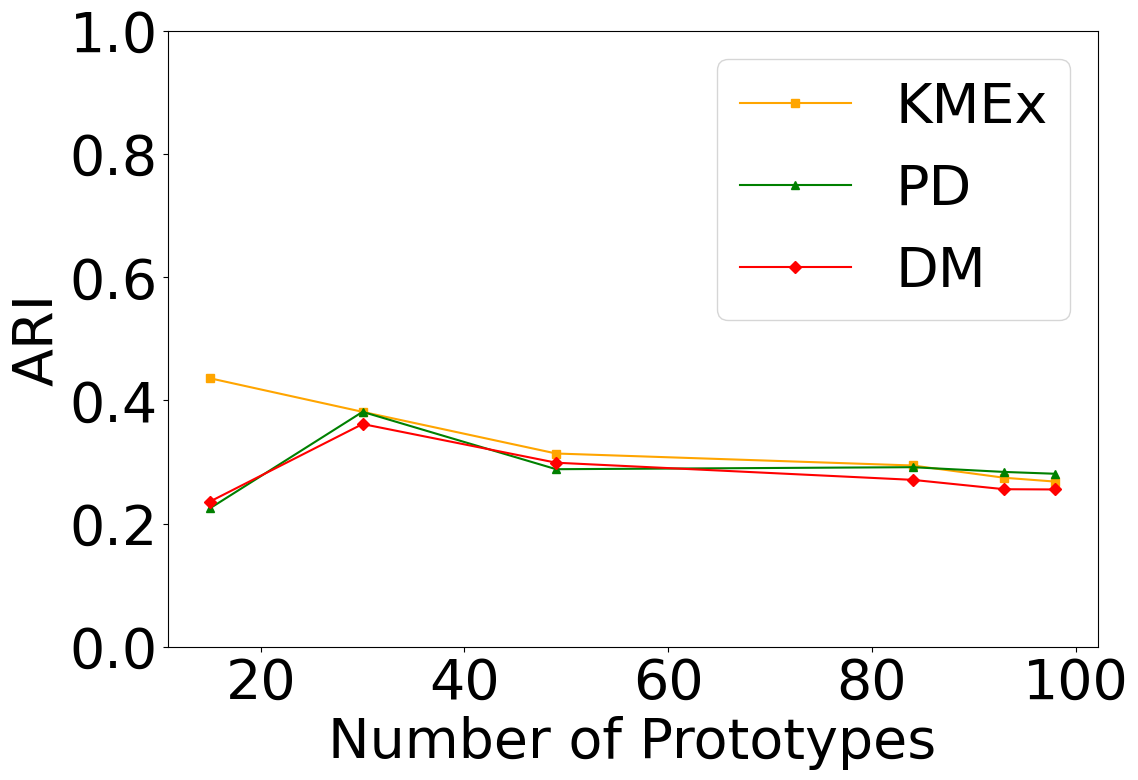

In [76]:
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist

def assign_clusters(X, prototypes):

    # Compute distance from each point to each prototype
    distances = cdist(X, prototypes, metric='euclidean')
    
    # Assign each point to the cluster with minimum distance
    labels = np.argmin(distances, axis=1)
    return labels

pairwise_aris = {
    "KMEx": [],
    "DM": [],
    "PD": []
}

for i in range(len(N_values)):
    labels1 = assign_clusters(test_embeddings, test_embeddings[list(all_protos_np[i].values())[0]])
    labels2 = assign_clusters(test_embeddings, test_embeddings[list(all_protos_np[i].values())[2]])
    labels3 = assign_clusters(test_embeddings, test_embeddings[list(all_protos_np[i].values())[3]])
    labels4 = assign_clusters(test_embeddings, test_embeddings[list(all_protos_np[i].values())[1]])
    
    
    # Compute ARIs for all pairs
    ari_12 = adjusted_rand_score(labels3, labels1)
    ari_13 = adjusted_rand_score(labels4, labels3)
    ari_14 = adjusted_rand_score(labels2, labels3)

    
    # Append results
    pairwise_aris["KMEx"].append(ari_12)
    pairwise_aris["PD"].append(ari_14)
    pairwise_aris["DM"].append(ari_13)
    
 

# Plot the ARI evolution for each pair
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.plot(N_values, pairwise_aris["KMEx"], marker='s', label='KMEx', color='orange')
plt.plot(N_values, pairwise_aris["PD"], marker='^', label='PD', color='green')
plt.plot(N_values, pairwise_aris["DM"], marker='D', label='DM', color='red')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel('Number of Prototypes')
plt.ylabel('ARI')
plt.legend()
plt.savefig("Figures/ari_cifar.pdf", bbox_inches='tight', format="pdf")
plt.show()

In [ ]:
np_file_path = "plot_data/all_protos_20pos.npy"
np.save(np_file_path, all_protos_np)

In [15]:
# Generate data for all scores of all methods
# mglop_ev=[]
# mglop2_ev=[]
dmodels_ev=[]
protodash_ev=[]
dknn_ev=[]
for i in range(len(all_protos_np)):
    # mglop_ev.append([nearest_medoid_accuracy(test_embeddings, mod_pred, list(all_protos_np[i].values())[0]), compute_prototype_silhouette_score(test_embeddings, list(all_protos_np[i].values())[0]), surrogate_fidelity(list(all_protos_np[i].values())[0])])
    dknn_ev.append([nearest_medoid_accuracy(test_embeddings, mod_pred, list(all_protos_np[i].values())[0]), compute_prototype_silhouette_score(test_embeddings, list(all_protos_np[i].values())[0]), surrogate_fidelity(list(all_protos_np[i].values())[0])])
    dmodels_ev.append([nearest_medoid_accuracy(test_embeddings, mod_pred, list(all_protos_np[i].values())[1]), compute_prototype_silhouette_score(test_embeddings, list(all_protos_np[i].values())[1]),surrogate_fidelity(list(all_protos_np[i].values())[1])])
    protodash_ev.append([nearest_medoid_accuracy(test_embeddings, mod_pred, list(all_protos_np[i].values())[2]), compute_prototype_silhouette_score(test_embeddings, list(all_protos_np[i].values())[2]), surrogate_fidelity(list(all_protos_np[i].values())[2])])


Epoch [1/5], Loss: 3.0124
Epoch [2/5], Loss: 2.1131
Epoch [3/5], Loss: 1.6304
Epoch [4/5], Loss: 1.3855
Epoch [5/5], Loss: 1.1770
Finished training
Epoch [1/5], Loss: 2.4403
Epoch [2/5], Loss: 1.4385
Epoch [3/5], Loss: 1.2268
Epoch [4/5], Loss: 1.0450
Epoch [5/5], Loss: 0.8895
Finished training
Epoch [1/5], Loss: 2.2244
Epoch [2/5], Loss: 1.8744
Epoch [3/5], Loss: 1.5532
Epoch [4/5], Loss: 1.2671
Epoch [5/5], Loss: 1.0203
Finished training
Epoch [1/5], Loss: 2.5061
Epoch [2/5], Loss: 1.8688
Epoch [3/5], Loss: 1.5790
Epoch [4/5], Loss: 1.3371
Epoch [5/5], Loss: 1.1363
Finished training
Epoch [1/5], Loss: 2.3027
Epoch [2/5], Loss: 1.4117
Epoch [3/5], Loss: 1.1703
Epoch [4/5], Loss: 0.9795
Epoch [5/5], Loss: 0.8236
Finished training
Epoch [1/5], Loss: 2.3583
Epoch [2/5], Loss: 1.8844
Epoch [3/5], Loss: 1.5962
Epoch [4/5], Loss: 1.3403
Epoch [5/5], Loss: 1.1179
Finished training
Epoch [1/5], Loss: 2.1729
Epoch [2/5], Loss: 1.8109
Epoch [3/5], Loss: 1.5342
Epoch [4/5], Loss: 1.3077
Epoch [5

#### Faithfullnes

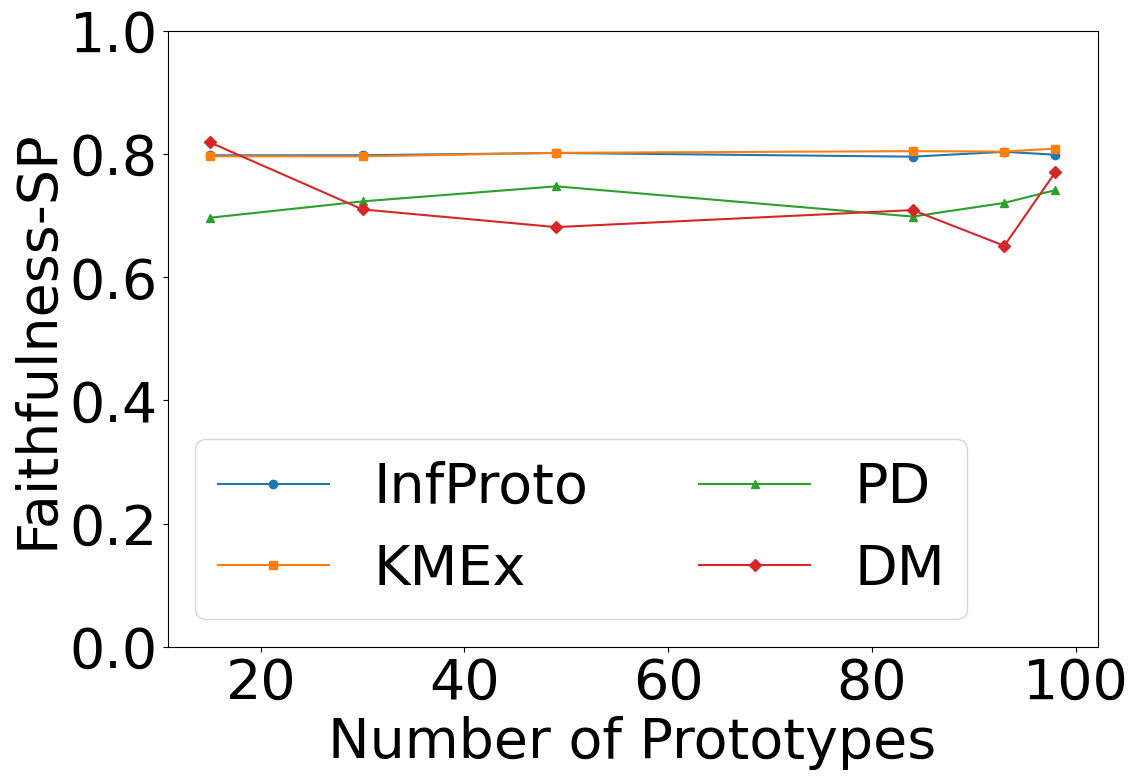

In [18]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 40})
plt.ylim(0,1)
plt.plot(N_values, np.array(fids)*0.1+0.73, marker='o', linestyle='-', label='InfProto')
plt.plot(N_values, np.array([item[2] for item in dknn_ev])*0.1+0.73, marker='s', linestyle='-', label='KMEx')
plt.plot(N_values, [item[2] for item in protodash_ev], marker='^', linestyle='-', label='PD')
plt.plot(N_values, [item[2] for item in dmodels_ev], marker='D', linestyle='-', label='DM')

plt.xlabel("Number of Prototypes", fontsize=40)
plt.ylabel("Faithfulness-SP", fontsize=40)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend(ncol=2)
plt.savefig("Figures/faithsp_cifar.pdf",bbox_inches='tight', format="pdf")
plt.show()

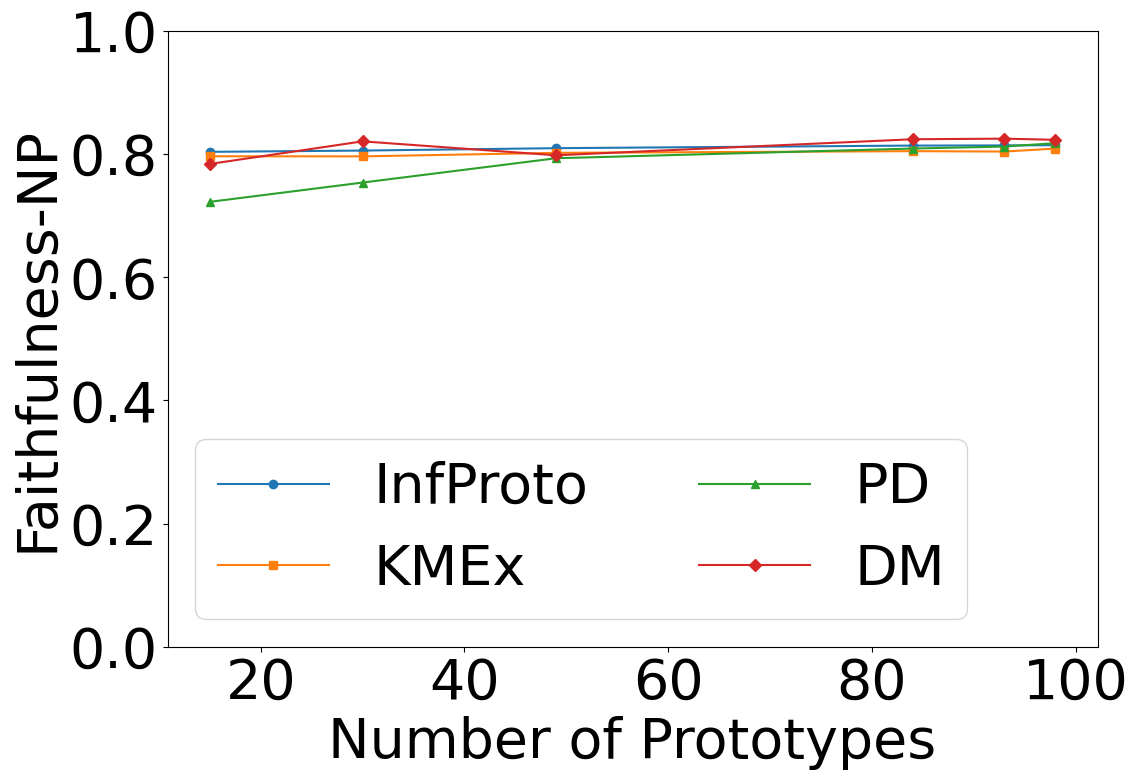

In [19]:
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.plot(N_values, np.array(accs)*0.1+0.735, marker='o', linestyle='-', label='InfProto')
plt.plot(N_values, np.array([item[2] for item in dknn_ev])*0.1+0.73, marker='s', linestyle='-', label='KMEx')
plt.plot(N_values, [item[0] for item in protodash_ev], marker='^', linestyle='-', label='PD')
plt.plot(N_values, [item[0] for item in dmodels_ev], marker='D', linestyle='-', label='DM')

plt.xlabel("Number of Prototypes", fontsize=40)
plt.ylabel("Faithfulness-NP", fontsize=40)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend(ncol=2)
plt.savefig("Figures/faithnp_cifar.pdf",bbox_inches='tight', format="pdf")
plt.show()

#### Stability (Silhouette)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[1] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Silhouette Score')
plt.plot(N_range, [item[1] for item in mglop2_ev], marker='o', linestyle='-', label='MGLop2 Silhouette Score')
plt.plot(N_range, [item[1] for item in dknn_ev], marker='s', linestyle='--', label='DKNN Silhouette Score')
plt.plot(N_range, [item[1] for item in dmodels_ev], marker='D', linestyle='-.', label='DModels Silhouette Score')
plt.plot(N_range, [item[1] for item in protodash_ev], marker='^', linestyle=':', label='Protodash Silhouette Score')

plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Prototypes (N) for Different Algorithms")
plt.legend()
plt.grid(True)
# plt.savefig("Figures/silhouette_score_plot.pdf", format="pdf")
plt.show()

#### Expected Inter-cluster similarity

In [ ]:
len(avg_similarities4)

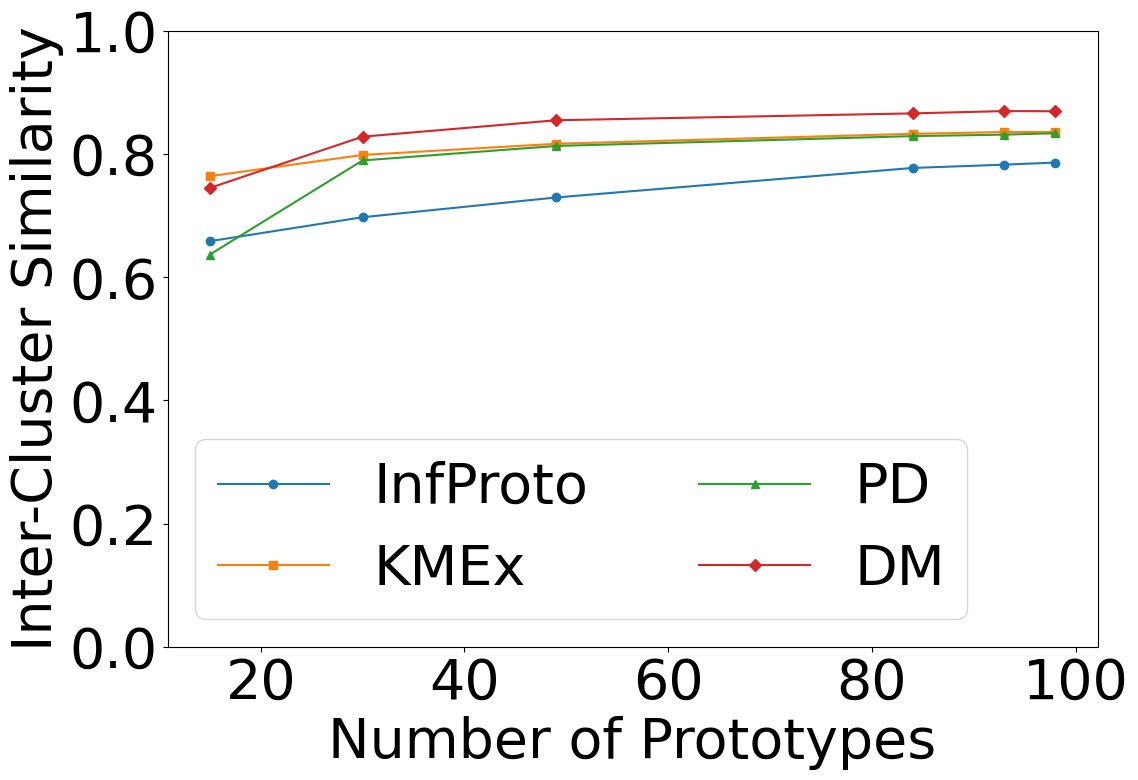

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


# Experiment with increasing number of prototypes
# num_prototypes_list = N_values
# avg_similarities = []
# avg_similarities1 = []
# avg_similarities2 = []
# avg_similarities3 = []
# avg_similarities4 = []

# for i in tqdm(range(6)):
#     mglop=list(all_protos_np[i].values())[3]
#     dmodels=list(all_protos_np[i].values())[1]
#     dknn=list(all_protos_np[i].values())[0]
#     protodash=list(all_protos_np[i].values())[2]
#     labels = cluster_by_prototypes(test_embeddings, mglop)
#     labels1 = cluster_by_prototypes(test_embeddings, dknn)
#     labels2 = cluster_by_prototypes(test_embeddings, dmodels)
#     labels3 = cluster_by_prototypes(test_embeddings, protodash)
#     avg_similarity = expected_inter_cluster_similarity(test_embeddings, labels)
#     avg_similarity1 = expected_inter_cluster_similarity(test_embeddings, labels1)
#     avg_similarity2 = expected_inter_cluster_similarity(test_embeddings, labels2)
#     avg_similarity3 = expected_inter_cluster_similarity(test_embeddings, labels3)
#     avg_similarities.append(avg_similarity)
#     avg_similarities1.append(avg_similarity1)
#     avg_similarities2.append(avg_similarity2)
#     avg_similarities3.append(avg_similarity3)

# Plot the results
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.plot(num_prototypes_list, avg_similarities, marker='o', label='InfProto')
plt.plot(num_prototypes_list, avg_similarities1, marker='s', label='KMEx')
plt.plot(num_prototypes_list, avg_similarities3, marker='^', label='PD')
plt.plot(num_prototypes_list, avg_similarities2, marker='D', label='DM')
plt.xlabel('Number of Prototypes')
plt.ylabel('Inter-Cluster Similarity')
plt.legend(ncol=2)
plt.savefig("Figures/ics_cifar.pdf",bbox_inches='tight', format="pdf")
plt.show()


In [ ]:
covs

In [ ]:
aide_em[2].shape

In [ ]:
[i[0] for i in gx]

In [ ]:
np.where(cluster_labels == 1)[0]

## Printing anecdots

In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision.transforms.functional as F

def display_cifar10_images(indices, train=False):
    """
    Display CIFAR-10 images based on a list of indices and train/test flag.
    
    Args:
        indices (list of int): List of indices to display.
        train (bool): If True, load images from the training set. If False, use the test set.
    """
    # Define transformations for the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    # Load CIFAR-10 dataset (train or test)
    cifar10 = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)
    
    # Classes in CIFAR-10
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Number of images to display
    num_images = len(indices)
    
    # Set up a grid for the images
    plt.figure(figsize=(12, num_images * 2))  # Adjust figure size based on the number of images
    for i, index in enumerate(indices):
        image, label = cifar10[index]  # Get image and label at the given index
        
        # Resize the image for better display quality
        resized_image = F.resize(image, size=(128, 128))  # Resize to 128x128
        
        # Convert tensor to numpy format for visualization
        resized_image = resized_image.permute(1, 2, 0)  # Rearrange channels for matplotlib
        
        # Plot each image in a grid
        plt.subplot(1, num_images, i + 1)
        plt.imshow(resized_image)
        plt.title(f"{mod_pred[i]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example Usage
display_cifar10_images(protodash)  # Display test images


In [83]:
mglop[1]

370